# Notebook - pipeline do trenowania modelu

## Zanim przejdziemy do trenowania modelu, przyjrzyjmy się wpierw danym, które mamy do dyspozycji. Zarówno z roku 2023 jak i 2024. Coś jakby pierwszy krok EDA.

### Na pierwszy ogień pójdą dane z 2023 roku:

In [55]:
#sekcja importowa
import os
import boto3
import mlflow
import pandas as pd
from io import BytesIO
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pycaret.regression import setup, compare_models, predict_model, evaluate_model, plot_model, finalize_model, save_model

In [2]:
# zobaczmy sobie wszystkie kolumny, bo nie jest ich aż tak dużo
pd.set_option('display.max_columns', None)

In [3]:
# wczytujemy pierwsza baze
bieg_2023_df = pd.read_csv('halfmarathon_wroclaw_2023__final.csv', sep=';')

In [4]:
# przylukajmy pare rekordow
bieg_2023_df.sample(5)

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,Kategoria wiekowa Miejsce,Rocznik,5 km Czas,5 km Miejsce Open,5 km Tempo,10 km Czas,10 km Miejsce Open,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
4686,4687.0,8002,JULIANNA,BEŚKA,WROCŁAW,POL,NaN,K,829.0,K20,170.0,2001.0,00:29:18,5629.0,5.860000,00:58:47,5647.0,5.896667,01:27:49,5260.0,5.806667,01:58:41,4807.0,6.173333,0.017000,02:03:48,5.868689
6324,6325.0,3830,MARZENA,HILASZEK,GLIWICE,POL,NaN,K,1432.0,K40,523.0,1978.0,00:31:26,6741.0,6.286667,01:02:44,6606.0,6.260000,01:35:17,6519.0,6.510000,02:10:49,6368.0,7.106667,0.054200,02:16:54,6.489689
2684,2685.0,4162,WOJCIECH,WRÓBLEWSKI,WROCŁAW,POL,RUGBY WROCŁAW,M,2391.0,M30,826.0,1987.0,00:25:27,2574.0,5.090000,00:50:28,2462.0,5.003333,01:17:12,2542.0,5.346667,01:46:49,2665.0,5.923333,0.056867,01:52:13,5.319586
550,551.0,1772,BARTOSZ,HOROSIEWICZ,ŁĘKA MROCZEŃSKA,POL,KS GEPARD KĘPNO,M,517.0,M30,201.0,1986.0,00:22:35,833.0,4.516667,00:44:46,787.0,4.436667,01:06:57,660.0,4.436667,01:30:34,569.0,4.723333,0.012400,01:34:42,4.489215
232,233.0,3615,ANDRZEJ,NOWAK,WROCŁAW,POL,GT RAT,M,222.0,M40,85.0,1982.0,00:20:14,227.0,4.046667,00:40:29,237.0,4.050000,01:01:47,252.0,4.260000,01:24:16,238.0,4.496667,0.031200,01:28:18,4.185826


In [5]:
# obejrzmy sobie nazwy i typy wszystkich kolumn
print(bieg_2023_df.dtypes)

Miejsce                      float64
Numer startowy                 int64
Imię                          object
Nazwisko                      object
Miasto                        object
Kraj                          object
Drużyna                       object
Płeć                          object
Płeć Miejsce                 float64
Kategoria wiekowa             object
Kategoria wiekowa Miejsce    float64
Rocznik                      float64
5 km Czas                     object
5 km Miejsce Open            float64
5 km Tempo                   float64
10 km Czas                    object
10 km Miejsce Open           float64
10 km Tempo                  float64
15 km Czas                    object
15 km Miejsce Open           float64
15 km Tempo                  float64
20 km Czas                    object
20 km Miejsce Open           float64
20 km Tempo                  float64
Tempo Stabilność             float64
Czas                          object
Tempo                        float64
d

#### Dużo tych kolumn, o wiele za dużo. Użytkownik, który w polu tekstowym mówi o swojej płci, wieku i prędkości, na pewno nie powie nam o numerze startowym, drużynie czy stabilności swojego tempa. Możemy więc bez żalu pozbyć się "kilku" kolumn.

In [6]:
# zostawiamy w bazie do dalszej analizy tylko ponizsze kolumny
bieg_2023_df = bieg_2023_df[['Płeć', 'Rocznik', '5 km Czas', 'Czas']]

In [7]:
# patrzymy, czy wyglada to juz lepiej
bieg_2023_df.sample(5)

,Płeć,Rocznik,5 km Czas,Czas
5595,M,1971.0,00:24:37,02:10:10
5898,K,1989.0,00:29:26,02:12:46
3591,M,1978.0,00:26:37,01:57:37
3255,M,2002.0,00:27:13,01:55:50
4749,M,1976.0,00:29:13,02:04:11


In [8]:
# sprawdzimy sobie ile wartosci nam brakuje
bieg_2023_df.isnull().sum()

Płeć           2
Rocznik      201
5 km Czas    827
Czas           0
dtype: int64

In [9]:
# a ile ich w ogole mamy?
len(bieg_2023_df)

8950

In [10]:
# usuwamy wartosci brakujace i sprawdzamy, ile nam zostalo
bieg_2023_clean_df = bieg_2023_df.dropna()
len(bieg_2023_clean_df)

7923

In [11]:
# a ile mamy wartosci rownych 0, bo one tez sa nam na grzyba
zero_count = (bieg_2023_clean_df['Rocznik'] == 0).sum()
print(zero_count)

9


In [12]:
zero_count = (bieg_2023_clean_df['5 km Czas'] == 0).sum()
print(zero_count)

0


In [13]:
zero_count = (bieg_2023_clean_df['Czas'] == 0).sum()
print(zero_count)

0


In [14]:
# usuwamy zerowcow obrzydliwych

bieg_2023_clean_df = bieg_2023_clean_df[bieg_2023_clean_df['Rocznik'] != 0]

#### Jak widać pozostało nam ok. 90% danych, to niewielki koszt uzyskania idealnych danych, bez żadnych braków. Na pewno szkolony model nam za to podziękuje.

In [15]:
# sprawdzanie na wszelki wypadek, czy cale zlo usunieto
bieg_2023_clean_df.isnull().sum()

Płeć         0
Rocznik      0
5 km Czas    0
Czas         0
dtype: int64

In [16]:
# zmieniamy rocznik na normalny intiger
bieg_2023_clean_df = bieg_2023_clean_df.assign(Rocznik=bieg_2023_clean_df['Rocznik'].round().astype(int))

# zamieniamy kolumnę rocznik na wiek biegacza w momencie biegu
bieg_2023_clean_df['Wiek'] = 2023 - bieg_2023_clean_df['Rocznik']
bieg_2023_clean_df = bieg_2023_clean_df.drop(columns=['Rocznik'])

# ustawiamy kolumny w milym dla oka porzadku
bieg_2023_clean_df = bieg_2023_clean_df[['Płeć', 'Wiek', '5 km Czas', 'Czas']]

In [17]:
# korzystamy z pomocy Andrzeja: Snippet pomocniczy - zmiana czasu na sekundy

def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF']:
        return None
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])

bieg_2023_clean_df = bieg_2023_clean_df.assign(
    Czas=bieg_2023_clean_df['Czas'].apply(convert_time_to_seconds),
    **{'5 km Czas': bieg_2023_clean_df['5 km Czas'].apply(convert_time_to_seconds)}
)

In [18]:
# na wszelki wypadek sprawdzamy kolumny i ich typy
print(bieg_2023_clean_df.dtypes)

Płeć         object
Wiek          int64
5 km Czas     int64
Czas          int64
dtype: object


In [19]:
# patrzymy, jak ostatecznie wyglada nasza baza
bieg_2023_clean_df.sample(5)

,Płeć,Wiek,5 km Czas,Czas
7108,K,37,1927,8826
7923,M,51,1841,9967
2804,M,55,1594,6787
2536,M,44,1532,6676
7351,M,30,2054,9046


#### Porównamy sobie teraz panie i panów

<Figure size 1000x1000 with 0 Axes>

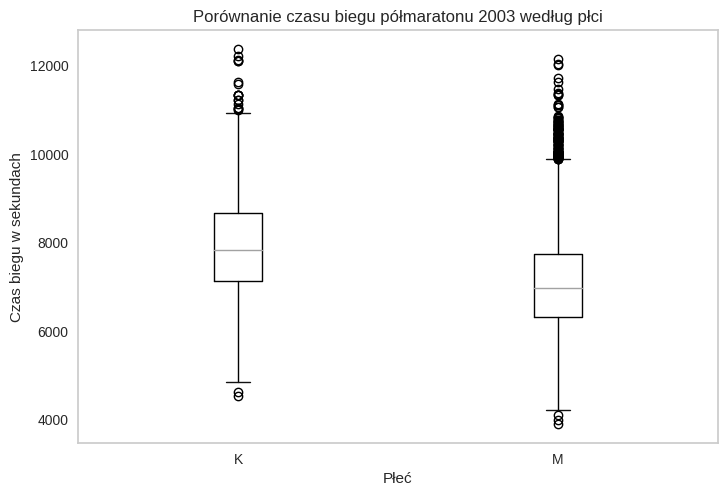

In [20]:
# Rysowanie boxplotów
plt.figure(figsize=(10, 10))  # Ustawia rozmiar wykresu
bieg_2023_clean_df.boxplot(column='Czas', by='Płeć', grid=False)

plt.title('Porównanie czasu biegu półmaratonu 2003 według płci')  # Tytuł wykresu
plt.suptitle('')  # Usuwa domyślny tytuł, który może być zbędny
plt.xlabel('Płeć')  # Etykieta osi X
plt.ylabel('Czas biegu w sekundach')  # Etykieta osi Y

# Wyświetlenie wykresu
plt.show()

#### Jest widoczna różnica. A jak to wygląda ze względu na wiek?

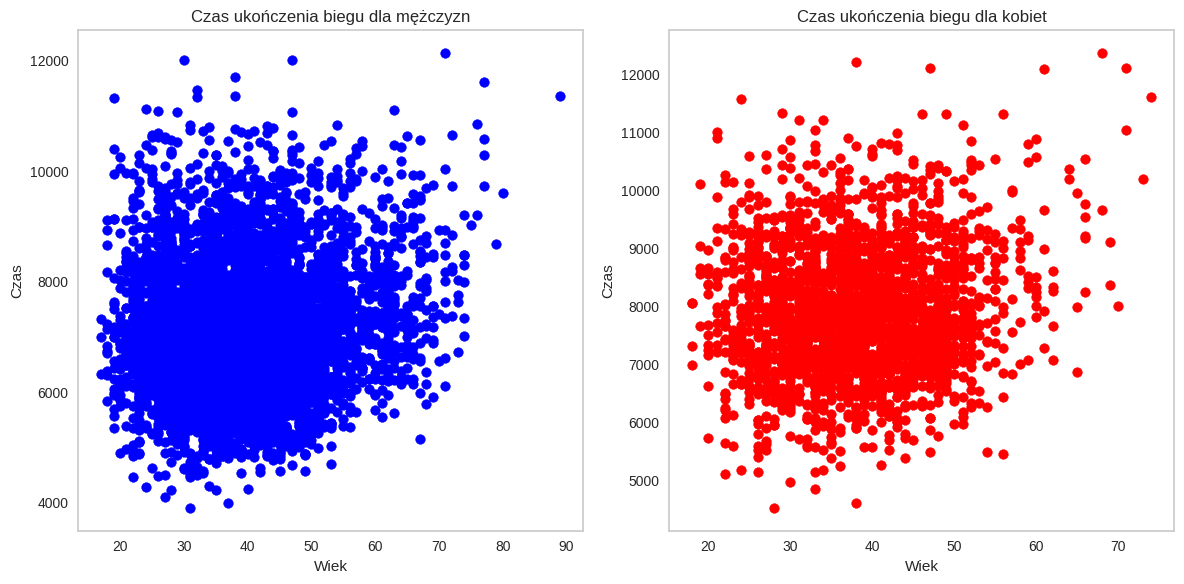

In [21]:
# Ustawienie wykresów
plt.figure(figsize=(12, 6))

# Wykres dla mężczyzn
plt.subplot(1, 2, 1)  # 1 row, 2 cols, subplot 1
men = bieg_2023_clean_df[bieg_2023_clean_df['Płeć'] == 'M']
plt.scatter(men['Wiek'], men['Czas'], color='blue')
plt.title('Czas ukończenia biegu dla mężczyzn')
plt.xlabel('Wiek')
plt.ylabel('Czas')
plt.grid()

# Wykres dla kobiet
plt.subplot(1, 2, 2)  # 1 row, 2 cols, subplot 2
women = bieg_2023_clean_df[bieg_2023_clean_df['Płeć'] == 'K']
plt.scatter(women['Wiek'], women['Czas'], color='red')
plt.title('Czas ukończenia biegu dla kobiet')
plt.xlabel('Wiek')
plt.ylabel('Czas')
plt.grid()

# Pokazanie wykresów
plt.tight_layout()  # Dostosowanie wykresów
plt.show()

#### No dobrze, widać że jak ktoś sprawnie przebiera nogami, to szybko jest na mecie. Wiek nie ma tu nic do gadania.

### Teraz zrobimy wszystko to samo dla roku 2024:

In [22]:
# wczytujemy druga baze
bieg_2024_df = pd.read_csv('halfmarathon_wroclaw_2024__final.csv', sep=';')

In [23]:
# na wszelki wypadek luknijmy na rekordy
bieg_2024_df.sample(5)

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,Kategoria wiekowa Miejsce,Rocznik,5 km Czas,5 km Miejsce Open,5 km Tempo,10 km Czas,10 km Miejsce Open,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
1274,1275.0,463,ADAM,MRUK,WROCŁAW,POL,NaN,M,1190.0,M20,205.0,1996.0,00:24:17,1712.0,4.856667,00:48:15,1756.0,4.793333,01:12:24,1538.0,4.830000,01:36:50,1355.0,4.886667,0.002533,01:41:45,4.823418
970,971.0,3864,BARTOSZ,PUDŁOWSKI,WROCŁAW,POL,T3TEAM,M,919.0,M50,70.0,1974.0,00:23:14,1081.0,4.646667,00:45:58,1069.0,4.546667,01:09:38,1026.0,4.733333,01:33:59,987.0,4.870000,0.017133,01:39:19,4.708067
10334,NaN,501,DIMITRIS,ATTILAKOS,NaN,NaN,Attilakos Running Team,M,NaN,M50,NaN,1971.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DNS,NaN
11830,NaN,23517,JAKUB,NIEWIŃSKI,NaN,NaN,NaN,M,NaN,M40,NaN,1982.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7194,7195.0,4552,PIOTR,BUSZKIEWICZ,POZNAŃ,POL,EUROCASH,M,5645.0,M40,1890.0,1981.0,00:30:39,7490.0,6.130000,01:01:10,7558.0,6.103333,01:33:10,7467.0,6.400000,02:05:53,7247.0,6.543333,0.030733,02:13:09,6.311922


In [24]:
# sprawdzimy sobie ile wartosci nam brakuje
bieg_2024_df.isnull().sum()

Miejsce                      2707
Numer startowy                  0
Imię                            0
Nazwisko                        0
Miasto                       3094
Kraj                         2707
Drużyna                      8026
Płeć                            9
Płeć Miejsce                 2707
Kategoria wiekowa              20
Kategoria wiekowa Miejsce    2718
Rocznik                       284
5 km Czas                    2719
5 km Miejsce Open            2719
5 km Tempo                   2719
10 km Czas                   2719
10 km Miejsce Open           2719
10 km Tempo                  2728
15 km Czas                   2720
15 km Miejsce Open           2720
15 km Tempo                  2730
20 km Czas                   2712
20 km Miejsce Open           2712
20 km Tempo                  2722
Tempo Stabilność             2740
Czas                         2055
Tempo                        2707
dtype: int64

#### Niedobrze :-( Brakuje nam prawie 1/4 wszystkich wartości. Ale nic nie możemy na to poradzić. Wiersze bez czasu biegu są nam nieprzydatne.

In [25]:
len(bieg_2024_df)

13007

In [26]:
# zostawiamy w bazie do dalszej analizy tylko ponizsze kolumny
bieg_2024_df = bieg_2024_df[['Płeć', 'Rocznik', '5 km Czas', 'Czas']]

In [27]:
# usuwamy wartosci brakujace i sprawdzamy, ile nam zostalo
bieg_2024_clean_df = bieg_2024_df.dropna()
len(bieg_2024_clean_df)

10004

In [28]:
# Sprawdzamy ile mamy wartosci rownych 0
zero_count = (bieg_2024_clean_df['Rocznik'] == 0).sum()
print(zero_count)

9


In [29]:
zero_count = (bieg_2024_clean_df['5 km Czas'] == 0).sum()
print(zero_count)

0


In [30]:
zero_count = (bieg_2024_clean_df['Czas'] == 0).sum()
print(zero_count)

0


In [31]:
# usuwamy zerowcow
bieg_2024_clean_df = bieg_2024_clean_df[bieg_2024_clean_df['Rocznik'] != 0]

In [32]:
# zmieniamy rocznik na normalny intiger
bieg_2024_clean_df = bieg_2024_clean_df.assign(Rocznik=bieg_2024_clean_df['Rocznik'].round().astype(int))

# zamieniamy kolumnę rocznik na wiek biegacza w momencie biegu
bieg_2024_clean_df['Wiek'] = 2024 - bieg_2024_clean_df['Rocznik']
bieg_2024_clean_df = bieg_2024_clean_df.drop(columns=['Rocznik'])

# ustawiamy kolumny w milym dla oka porzadku
bieg_2024_clean_df = bieg_2024_clean_df[['Płeć', 'Wiek', '5 km Czas', 'Czas']]

In [33]:
# korzystamy z pomocy Andrzeja: Snippet pomocniczy - zmiana czasu na sekundy

def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF']:
        return None
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])

bieg_2024_clean_df = bieg_2024_clean_df.assign(
    Czas=bieg_2024_clean_df['Czas'].apply(convert_time_to_seconds),
    **{'5 km Czas': bieg_2024_clean_df['5 km Czas'].apply(convert_time_to_seconds)}
)

#### Sprawdzamy różnice ze zwględu na płeć

<Figure size 1000x1000 with 0 Axes>

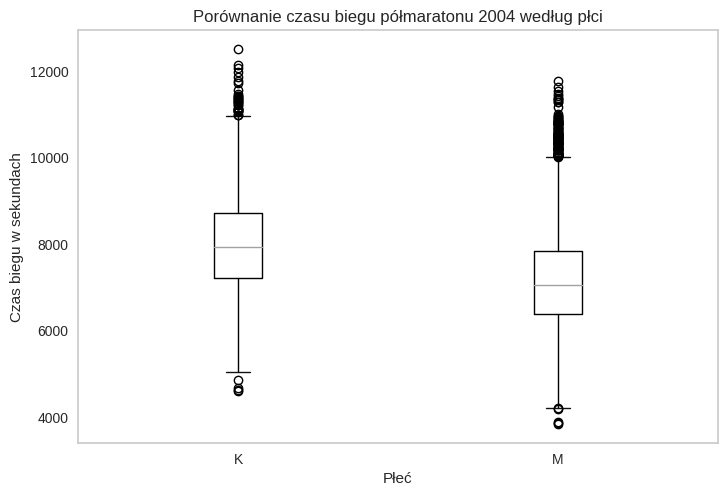

In [34]:
# Rysowanie boxplotów
plt.figure(figsize=(10, 10))  # Ustawia rozmiar wykresu
bieg_2024_clean_df.boxplot(column='Czas', by='Płeć', grid=False)

plt.title('Porównanie czasu biegu półmaratonu 2004 według płci')  # Tytuł wykresu
plt.suptitle('')  # Usuwa domyślny tytuł, który może być zbędny
plt.xlabel('Płeć')  # Etykieta osi X
plt.ylabel('Czas biegu w sekundach')  # Etykieta osi Y

# Wyświetlenie wykresu
plt.show()

#### Tak, różnice nadal są widoczne. Na wszelki wypadek, sprawdzamy ze względu na wiek, bo a nuż coś się zmieniło?

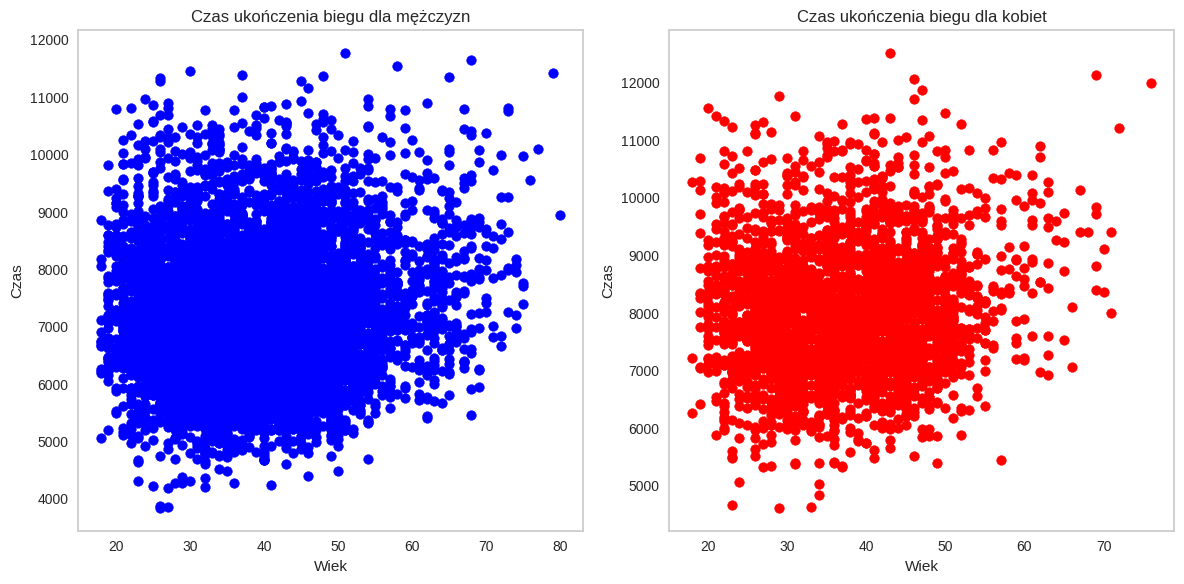

In [35]:
# Ustawienie wykresów
plt.figure(figsize=(12, 6))

# Wykres dla mężczyzn
plt.subplot(1, 2, 1)  # 1 row, 2 cols, subplot 1
men = bieg_2024_clean_df[bieg_2024_clean_df['Płeć'] == 'M']
plt.scatter(men['Wiek'], men['Czas'], color='blue')
plt.title('Czas ukończenia biegu dla mężczyzn')
plt.xlabel('Wiek')
plt.ylabel('Czas')
plt.grid()

# Wykres dla kobiet
plt.subplot(1, 2, 2)  # 1 row, 2 cols, subplot 2
women = bieg_2024_clean_df[bieg_2024_clean_df['Płeć'] == 'K']
plt.scatter(women['Wiek'], women['Czas'], color='red')
plt.title('Czas ukończenia biegu dla kobiet')
plt.xlabel('Wiek')
plt.ylabel('Czas')
plt.grid()

# Pokazanie wykresów
plt.tight_layout()  # Dostosowanie wykresów
plt.show()

#### Taka sama kaszana.

## Przechodzimy więc do umieszczenia danych w Digital Ocean.

In [36]:
# ladujemy klucze
load_dotenv()
BUCKET_NAME='halfmarathon-space'

# nawiazujemy kontakt z naszym wiadrem w Digital Ocean
s3 = boto3.client(
    "s3",
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    # Endpoint jest potrzebny dlatego że używamy chmury innej niż AWS 
    endpoint_url=os.getenv("AWS_ENDPOINT_URL_S3"), 
    # Gdybyśmy używali AWS to musielibyśmy natomiast podać region
    #region_name='eu-central-1'
)

try:
    s3.head_bucket(Bucket=BUCKET_NAME)
    print('Wszystko OK. Połączenie z bazą danych w Digital Ocean zostało nawiązane poprawnie i działa')
except Exception as e:
    print(f"Błąd połączenia z bazą danych w Digital Ocean z powodu: {str(e)}")

Wszystko OK. Połączenie z bazą danych w Digital Ocean zostało nawiązane poprawnie i działa


## Kod jest tak napisany, żeby w przyszłości można było działać na większej ilości plików z kolejnych lat (gdyby ktoś miał taką fantazję).

In [37]:
# wyszukiwanie plików zaczynających się od 'halfmarathon_'
current_directory = os.getcwd()
files_to_upload = [f for f in os.listdir(current_directory) if f.startswith("halfmarathon_")]

# wysylamy teraz pliki z danymi z polmaratonow do naszego Cloud Storage w Digital Ocean
for file_name in files_to_upload:
    file_path = os.path.join(current_directory, file_name)
    s3_path = file_name.replace("\\", "/")
    print(f"Wysyłam plik {file_path} do {s3_path}")
    s3.upload_file(
        Filename=file_path,
        Bucket=BUCKET_NAME,
        Key=s3_path
    )

Wysyłam plik /home/rafal/Projekty/od_zera_do_ai/modul_9/homework/halfmarathon_wroclaw_2024__final.csv do halfmarathon_wroclaw_2024__final.csv
Wysyłam plik /home/rafal/Projekty/od_zera_do_ai/modul_9/homework/halfmarathon_wroclaw_2023__final.csv do halfmarathon_wroclaw_2023__final.csv


In [38]:
# sprawdzamy, czy sie udalo i mamy tam pliki na Digital Ocean
response = s3.list_objects_v2(Bucket=BUCKET_NAME)

if "Contents" in response:
    print(f"Pliki w bucket {BUCKET_NAME}:")
    for obj in response.get("Contents", []):
        print(obj["Key"])
else:
    print(f"Brak plików w bucket {BUCKET_NAME}.")

Pliki w bucket halfmarathon-space:
halfmarathon_wroclaw_2023__final.csv
halfmarathon_wroclaw_2024__final.csv


## Zczytujemy dane z Digital Ocean.

In [39]:
# wczytujemy nasze pliki z Digital Ocean w locie, bez zapisywania ich na dysk
response = s3.list_objects_v2(Bucket=BUCKET_NAME)

## Sprawdzamy, czy są jakieś pliki
if "Contents" in response and len(response["Contents"]) > 0:
    for i, obj in enumerate(response["Contents"]):
        file_key = obj["Key"]
        
        # Używamy BytesIO do pobrania pliku w locie
        obj_data = s3.get_object(Bucket=BUCKET_NAME, Key=file_key)
        data = obj_data['Body'].read()  # Pobieramy dane pliku
        
        # Wczytanie danych do DataFrame z użyciem separatora ';'
        df = pd.read_csv(BytesIO(data), sep=';')

        # Nazwa DataFrame na podstawie roku
        year = 2023 + i
        globals()[f'bieg_{year}_df'] = df
        
        print(f"Wczytano plik z bucketu: {BUCKET_NAME} o nazwie: {file_key}. Utworzono DataFrame: bieg_{year}_df.")
else:
    print(f"Brak dostępnych plików w buckecie {BUCKET_NAME}.")

Wczytano plik z bucketu: halfmarathon-space o nazwie: halfmarathon_wroclaw_2023__final.csv. Utworzono DataFrame: bieg_2023_df.
Wczytano plik z bucketu: halfmarathon-space o nazwie: halfmarathon_wroclaw_2024__final.csv. Utworzono DataFrame: bieg_2024_df.


## Czyścimy dane "w locie"

In [40]:
# definiujemy proces czyszczenia danych
def process_race_data(df, year):
    # Filtrujemy kolumny
    df = df[['Płeć', 'Rocznik', '5 km Czas', 'Czas']]
    
    # Usuwamy wiersze z NaN i wartości 0 w kolumnie 'Rocznik'
    df = df.dropna().loc[df['Rocznik'] != 0]

    # Zmieniamy 'Rocznik' na typ integer
    df['Rocznik'] = df['Rocznik'].round().astype(int)
    
    # Tworzymy kolumnę 'Wiek'
    df['Wiek'] = year - df['Rocznik']
    
    # Usuwamy kolumnę 'Rocznik'
    df = df.drop(columns=['Rocznik'])
    
    # Ustawiamy kolumny w czytelnej kolejności
    df = df[['Płeć', 'Wiek', '5 km Czas', 'Czas']]
    
    # Konwertujemy czas na sekundy
    df['Czas'] = df['Czas'].apply(convert_time_to_seconds)
    df['5 km Czas'] = df['5 km Czas'].apply(convert_time_to_seconds)
    
    return df

In [41]:
year = 2023  # Rozpoczynamy od roku 2023

while True:  # Kontynuuj dopóki są dostępne DataFrame'y
    df_name = f'bieg_{year}_df'
    
    # Sprawdź, czy DataFrame o danej nazwie istnieje
    if df_name in globals():
        globals()[df_name] = process_race_data(globals()[df_name], year)
        year += 1  # Przechodzimy do następnego roku
    else:
        print(f"Brak DataFrame'u {df_name}. Zakończono przetwarzanie.")
        break  # Kończymy, jeśli DataFrame nie istnieje

Brak DataFrame'u bieg_2025_df. Zakończono przetwarzanie.


In [42]:
# sprawdzamy na wszelki wypadek, czy wszystko jest OK
bieg_2023_df.sample(5)

,Płeć,Wiek,5 km Czas,Czas
325,K,26,1192,5402
6451,K,42,1900,8295
227,M,49,1212,5291
3163,M,34,1569,6911
1553,M,42,1481,6302


## Przystępujemy do wyboru i terenowania modelu.
### Zrobimy tak, że dane z roku 2023 zostana przeznaczone do wytrenowania modelu, a dane z roku 2024 do jego przetestowania.

In [43]:
exp = setup(
    data=bieg_2023_df,
    target='Czas',
    session_id=123,
    verbose=False,
    categorical_features=['Płeć'],
    numeric_features=['Wiek', '5 km Czas']
)

In [44]:
best_model = exp.compare_models(sort='R2')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,289.4654,163273.9844,403.6826,0.8870,0.0513,0.0380,0.1840
lightgbm,Light Gradient Boosting Machine,296.6885,172558.4836,415.0751,0.8807,0.0525,0.0389,21.2360
knn,K Neighbors Regressor,313.9620,191101.9177,436.8169,0.8678,0.0557,0.0413,0.0350
en,Elastic Net,295.9051,192089.6218,434.3866,0.8663,0.0529,0.0388,0.0320
omp,Orthogonal Matching Pursuit,295.8321,192120.5197,434.4338,0.8663,0.0529,0.0388,0.0310
br,Bayesian Ridge,295.8899,192067.5978,434.3633,0.8663,0.0529,0.0388,0.0320
ridge,Ridge Regression,296.0021,192212.4994,434.5219,0.8662,0.0529,0.0388,0.0320
lar,Least Angle Regression,296.0022,192212.6771,434.5221,0.8662,0.0529,0.0388,0.0330
llar,Lasso Least Angle Regression,295.9350,192130.4305,434.4315,0.8662,0.0529,0.0388,0.0330
lasso,Lasso Regression,295.9350,192130.4299,434.4315,0.8662,0.0529,0.0388,0.0330


In [45]:
best_model = exp.compare_models(sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,289.4654,163273.9844,403.6826,0.8870,0.0513,0.0380,0.1800
lightgbm,Light Gradient Boosting Machine,296.6885,172558.4836,415.0751,0.8807,0.0525,0.0389,23.1790
br,Bayesian Ridge,295.8899,192067.5978,434.3633,0.8663,0.0529,0.0388,0.0460
en,Elastic Net,295.9051,192089.6218,434.3866,0.8663,0.0529,0.0388,0.0320
lasso,Lasso Regression,295.9350,192130.4299,434.4315,0.8662,0.0529,0.0388,0.0320
llar,Lasso Least Angle Regression,295.9350,192130.4305,434.4315,0.8662,0.0529,0.0388,0.0330
omp,Orthogonal Matching Pursuit,295.8321,192120.5197,434.4338,0.8663,0.0529,0.0388,0.0370
ridge,Ridge Regression,296.0021,192212.4994,434.5219,0.8662,0.0529,0.0388,0.0320
lar,Least Angle Regression,296.0022,192212.6771,434.5221,0.8662,0.0529,0.0388,0.0330
lr,Linear Regression,296.0022,192212.6771,434.5221,0.8662,0.0529,0.0388,0.0330


### W przypadku obu metryk najlepszym okazał się model **gbr**.

#### Sprawdzimy teraz, jak sobie radzi nasz model na danych, których wcześniej nie widział.

In [46]:
# porownanie efektow treningu
trening = predict_model(best_model, data=bieg_2023_df)
# z przewidywaniem wynikow na nowym zbiorze
predict = predict_model(best_model, data=bieg_2024_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,282.2056,154422.9401,392.9668,0.8951,0.0499,0.0370


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,340.5979,195393.8821,442.0338,0.8661,0.0560,0.0451


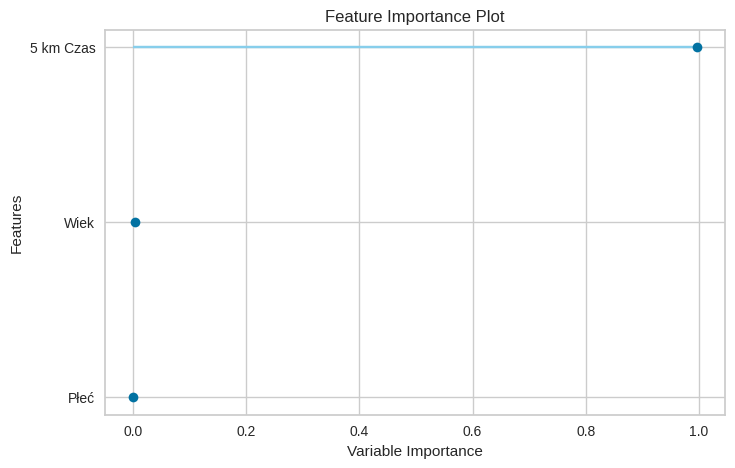

In [47]:
# sprawdzmy jeszcze kolejnosc istotnosci danych
exp.plot_model(best_model, plot='feature')

#### Hmm, więc płeć jednak nie ma znaczenia? Trochę inaczej mi się wydawało, gdy analizowałem dane na początku...

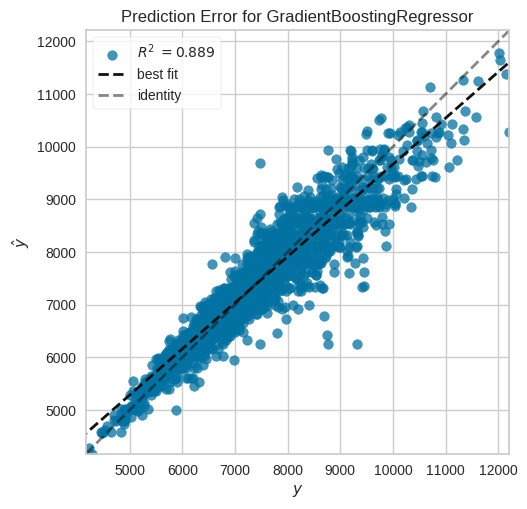

In [48]:
# zobaczmy jeszcze wykres bledow (residuals), a konkretnie, jak dobrze model przewiduje dane w porownaniu do rzeczywistych wartosci
exp.plot_model(best_model, plot='error')

### Wzbogaćmy teraz nasz model trenując go na całym zbiorze danych.

In [51]:
# Sprawdź, czy bieg_2023_df i bieg_2024_df są gotowe i mają te same struktury kolumn
combined_data = pd.concat([bieg_2023_df, bieg_2024_df], ignore_index=True)

# Inicjalizacja setup na całym zbiorze danych
exp = setup(data=combined_data, target='Czas', session_id=123, verbose=False)

# Trening najlepszego modelu (best_model) na nowym zbiorze danych
best_final_model = finalize_model(best_model)

In [53]:
# Zobaczymy, czy sie poprawił i o ile
stary = predict_model(best_model, data=combined_data)
nowy = predict_model(best_final_model, data=combined_data)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,314.7943,177288.7933,421.0568,0.8792,0.0534,0.0415


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,294.3226,164077.1275,405.0643,0.8882,0.0513,0.0385


### Znaczenie i interpretacja poszczególnych metryki naszego modelu:

1. **MAE (Mean Absolute Error) = 294.32**: \
MAE mierzy przeciętną wielkość błędów przewidywań bez względu na kierunek. Jest to stosunkowo przystępna miara, która w naszym przypadku oznacza, że przeciętny błąd w przewidywaniu czasu ukończenia biegu wynosi około 294 sekund (około 5 minut). Im mniejsza wartość, tym lepiej.

2. **MSE (Mean Squared Error) = 164077.13** i **RMSE (Root Mean Squared Error) = 405.06**: \
MSE i RMSE są bardziej czułymi metrykami na duże błędy, ponieważ błędy są podnoszone do kwadratu. RMSE wynoszące 405 sekund (niemal 7 minut) sugeruje, że dla niektórych prognoz może to być dość znaczący błąd. Mimo to, RMSE jest standardowym wskaźnikiem wydajności modelu regresyjnego.

3. **R2 (R-squared) = 0.8882**: \
R² mierzy, jak dużo wariancji w danych jest wyjaśniane przez model. Wartość 0.8882 oznacza, że model wyjaśnia 88.82% wariancji w danych, co jest bardzo dobrym wynikiem. Wskazuje na to, że model dobrze odpowiada na zależności w danych.

4. **RMSLE (Root Mean Squared Logarithmic Error) = 0.0513**: \
RMSLE jest przydatne, gdy różnice w wartościach są istotne. Metryka ta jest mała, co sugeruje, że model dobrze poradził sobie w przewidywaniu logarytmicznego błędu. 

5. **MAPE (Mean Absolute Percentage Error) = 0.0385**: \
MAPE określa, jak duże są błędy w procentach. Wartość 0.0385 (około 3.85%) oznacza, że model ma stosunkowo małe błędy w procentach, co jest dobrą wiadomością.

### Podsumowanie
Na podstawie tych metryk można stwierdzić, że model **Gradient Boosting Regressor** jest naprawdę dobry. Model ma niskie wartości MAE, RMSE i MAPE, co wskazuje na dobre prognozy. Ponadto wartość R² bliska 0.9 sugeruje, że model wychwytuje większość istotnych zależności w danych.

#### Hmm, jest dobrze, ale d... nie urywa. No trudno. Idziemy dalej z tym, co mamy.

In [56]:
# Zapiszemy sobie nasz model lokalnie
save_model(best_final_model, 'maraton_rafal_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Wiek', '5 km Czas'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=OrdinalEncoder(cols=['Płeć'],
                                                                handle_missing='return_nan',
                                                                mapping=[{'col': 'Płeć',
                                                                          'data_type': dtype('O'),
                                                                          'mapping': K      0
 M      1
 NaN   -1
 dtype: int64}]))),
          

In [60]:
# umiescimy go w Digital Ocean
s3.upload_file('maraton_rafal_model.pkl', BUCKET_NAME, 'maraton_rafal_model.pkl')